In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import datetime
from scipy.stats import pearsonr

# import multiprocessing as mp
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)

### Get Teams

In [2]:
dfTeams = pd.read_csv('teams.csv')
dfTeams.conference = dfTeams.conference.apply(lambda c: c.split(' (')[0])

In [3]:
dfTeams.head()

,conference,team,tm_link,year
0,ACC,Duke,duke,2001
1,Pac-10,Arizona,arizona,2001
2,Pac-10,Stanford,stanford,2001
3,Big Ten,Michigan State,michigan-state,2001
4,ACC,Maryland,maryland,2001


### Get Game Summaries

In [4]:
dfGames = pd.read_csv('games_summary.csv')

/home/chris/anaconda/lib/python2.7/site-packages/pandas/io/parsers.py:1159: DtypeWarning: Columns (5,11) have mixed types. Specify dtype option on import or set low_memory=False.
  data = self._reader.read(nrows)


In [5]:
dfGames['dt'] = dfGames.box.apply(lambda g: datetime.datetime.strptime(g[:10], "%Y-%m-%d").date() )
dfGames['season'] = dfGames.dt.apply(lambda d:  d.year+1 if d.month > 4 else d.year)

REORDER_GAME_COLUMNS = ['season', 'Team', 'G', 'Date', 'Year', 'dt', 'box', 'Type', 'Opponent', 'Conf', 'Result', 'Tm', 'Opp', 'OT', 'W', 'L', 'Streak', 'Network', 'Time']
dfGames = dfGames[REORDER_GAME_COLUMNS]

dfGames = dfGames.merge(dfTeams[['year', 'team', 'tm_link']],
                        how = 'left',
                        left_on = ['season', 'Opponent'],
                        right_on = ['year', 'team'],
                        suffixes = ['', '_y']
                        )
dfGames.rename(columns = {'tm_link' : 'opp_link'}, inplace = True) 
dfGames.drop(['Network', 'Time', 'Date', 'year', 'team'], inplace = True, axis = 1)

dfGames.columns = [c.lower() for c in dfGames.columns]

In [6]:
dfGames.head()

,season,team,g,year,dt,box,type,opponent,conf,result,tm,opp,ot,w,l,streak,opp_link
0,2011,ohio-state,1,2011,2010-11-12,2010-11-12-ohio-state,REG,North Carolina A&T,MEAC,W,102,61,NaN,1,0,W 1,north-carolina-at
1,2011,ohio-state,2,2011,2010-11-16,2010-11-16-florida,REG,Florida,SEC,W,93,75,NaN,2,0,W 2,florida
2,2011,ohio-state,3,2011,2010-11-20,2010-11-20-ohio-state,REG,North Carolina-Wilmington,CAA,W,81,41,NaN,3,0,W 3,north-carolina-wilmington
3,2011,ohio-state,4,2011,2010-11-23,2010-11-23-ohio-state,REG,Morehead State,OVC,W,64,45,NaN,4,0,W 4,morehead-state
4,2011,ohio-state,5,2011,2010-11-26,2010-11-26-ohio-state,REG,Miami (OH),MAC,W,66,45,NaN,5,0,W 5,miami-oh


### Get TeamGame Stats

In [7]:
df_stats = pd.read_csv('player_stats.csv')
df_stats.drop(df_stats.columns[0], axis = 1, inplace= True)
df_stats_backup = df_stats.copy()


REORDER_COLS = ['player_id', 'player', 'team', 'gm', 'mp', 'fg', 'fga', 'fg_pct', 'fg2', 'fg2a', 'fg2_pct', 'fg3', 'fg3a', 'fg3_pct', 'ft', 'fta', 'ft_pct', 'orb', 'drb', 'trb', 'ast', 'stl', 'blk', 'tov', 'pf', 'pts']

df_stats = df_stats[REORDER_COLS]
df_stats.insert(3, 'dt', df_stats.gm.apply(lambda g: datetime.datetime.strptime(g[:10], "%Y-%m-%d").date() ))
df_stats.sort(['dt', 'gm', 'team', 'player_id'], inplace = True)

df_stats.reset_index(inplace = True, drop = True)

df_stats.insert(4, 'season', df_stats.dt.apply(lambda d:  d.year+1 if d.month > 4 else d.year))
df_stats.insert(6, 'home_team', df_stats.apply(lambda r: r.team in r.gm, axis = 1))

In [8]:
df_stats.head()

,player_id,player,team,dt,season,gm,home_team,mp,fg,fga,fg_pct,fg2,fg2a,fg2_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts
0,chris-mcnealy-2,Chris McNealy,california-irvine,2010-11-08,2011,2010-11-08-illinois,False,21,3,5,0.600,1,3,0.333,2,2,1.0,0,0,NaN,0,3,3,1,0,1,2,2,8
1,daman-starring-1,Daman Starring,california-irvine,2010-11-08,2011,2010-11-08-illinois,False,19,1,5,0.200,1,4,0.250,0,1,0.0,1,1,1.000,1,1,2,1,1,0,0,1,3
2,darren-moore-1,Darren Moore,california-irvine,2010-11-08,2011,2010-11-08-illinois,False,24,5,9,0.556,2,4,0.500,3,5,0.6,5,7,0.714,1,2,3,1,3,0,3,3,18
3,derick-flowers-1,Derick Flowers,california-irvine,2010-11-08,2011,2010-11-08-illinois,False,5,1,4,0.250,1,2,0.500,0,2,0.0,0,0,NaN,0,1,1,1,0,0,0,1,2
4,derrick-strings-1,Derrick Strings,california-irvine,2010-11-08,2011,2010-11-08-illinois,False,11,0,2,0.000,0,2,0.000,0,0,NaN,0,0,NaN,0,1,1,0,0,0,2,1,0


In [10]:
numb_cols = df_stats.columns[7:]

In [11]:
dfTeamGames = df_stats.groupby(['season', 'dt', 'gm', 'team', 'home_team'], as_index = False)[numb_cols].sum()

In [12]:
dfTeamGames = dfTeamGames.merge(dfGames[['season', 'team', 'opp_link', 'box']],
                                how = 'left',
                                left_on = ['season', 'team', 'gm'],
                                right_on = ['season', 'team', 'box'],
                                suffixes = ['', '_y']
                                )

dfTeamGames.drop('box', axis = 1, inplace = True)

In [13]:
dfTeamGames = dfTeamGames.merge(dfTeams[['year', 'tm_link', 'conference']],
                                how = 'left',
                                left_on = ['season', 'team'],
                                right_on = ['year', 'tm_link'],
                                suffixes = ['', '_y']
                                )

dfTeamGames.drop(['year', 'tm_link'], axis = 1, inplace = True)

In [14]:
dfTeamGames = dfTeamGames.merge(dfTeams[['year', 'tm_link', 'conference']],
                                how = 'left',
                                left_on = ['season', 'opp_link'],
                                right_on = ['year', 'tm_link'],
                                suffixes = ['', '_y']
                                )

dfTeamGames.drop(['year', 'tm_link'], axis = 1, inplace = True)
dfTeamGames.rename(columns = {'conference_y' : 'opp_conference'}, inplace = True)

In [15]:
dfTeamGames.insert(5,'conf_game',  dfTeamGames.conference == dfTeamGames.opp_conference)

In [16]:
for c in dfTeamGames.columns:
    if 'pct' in c:
        print c.split('_')[0], c.split('_')[0]+'a'
        dfTeamGames[c] = dfTeamGames[c.split('_')[0]].map(float)/dfTeamGames[c.split('_')[0]+'a'].map(float)

fg fga
fg2 fg2a
fg3 fg3a
ft fta


In [17]:
dfTeamGames = dfTeamGames.merge(dfTeamGames[['gm', 'team'] + numb_cols.tolist()],
                                how = 'left',
                                left_on = ['gm', 'opp_link'],
                                right_on = ['gm', 'team'],
                                suffixes = ['', '_opp']
                                )

In [18]:
dfTeamGames.insert(6, 'result_win', dfTeamGames.pts > dfTeamGames.pts_opp)

In [19]:
for nc in numb_cols[1:]:
    colName = nc + '_net'
    dfTeamGames[colName] = dfTeamGames[nc] - dfTeamGames[nc + '_opp']

In [20]:
dfTeamGames.tail(6)

,season,dt,gm,team,home_team,conf_game,result_win,mp,fg,fga,fg_pct,fg2,fg2a,fg2_pct,fg3,fg3a,fg3_pct,ft,fta,ft_pct,orb,drb,trb,ast,stl,blk,tov,pf,pts,opp_link,conference,opp_conference,team_opp,mp_opp,fg_opp,fga_opp,fg_pct_opp,fg2_opp,fg2a_opp,fg2_pct_opp,fg3_opp,fg3a_opp,fg3_pct_opp,ft_opp,fta_opp,ft_pct_opp,orb_opp,drb_opp,trb_opp,ast_opp,stl_opp,blk_opp,tov_opp,pf_opp,pts_opp,fg_net,fga_net,fg_pct_net,fg2_net,fg2a_net,fg2_pct_net,fg3_net,fg3a_net,fg3_pct_net,ft_net,fta_net,ft_pct_net,orb_net,drb_net,trb_net,ast_net,stl_net,blk_net,tov_net,pf_net,pts_net
58388,2015,2015-04-04,2015-04-04-duke,duke,True,False,True,200,26,50,0.520000,24,40,0.600000,2,10,0.200000,27,37,0.729730,7,29,36,10,9,4,8,18,81,michigan-state,ACC,Big Ten,michigan-state,200,22,55,0.400000,15,35,0.428571,7,20,0.350000,10,16,0.625000,8,23,31,10,4,3,14,28,61,4,-5,0.120000,9,5,0.171429,-5,-10,-0.150000,17,21,0.104730,-1,6,5,0,5,1,-6,-10,20
58389,2015,2015-04-04,2015-04-04-duke,michigan-state,False,False,False,200,22,55,0.400000,15,35,0.428571,7,20,0.350000,10,16,0.625000,8,23,31,10,4,3,14,28,61,duke,Big Ten,ACC,duke,200,26,50,0.520000,24,40,0.600000,2,10,0.200000,27,37,0.729730,7,29,36,10,9,4,8,18,81,-4,5,-0.120000,-9,-5,-0.171429,5,10,0.150000,-17,-21,-0.104730,1,-6,-5,0,-5,-1,6,10,-20
58390,2015,2015-04-04,2015-04-04-kentucky,kentucky,True,False,False,200,26,54,0.481481,23,49,0.469388,3,5,0.600000,9,10,0.900000,6,16,22,7,5,4,6,20,64,wisconsin,SEC,Big Ten,wisconsin,200,23,48,0.479167,16,31,0.516129,7,17,0.411765,18,22,0.818182,9,21,30,10,1,2,10,14,71,3,6,0.002315,7,18,-0.046741,-4,-12,0.188235,-9,-12,0.081818,-3,-5,-8,-3,4,2,-4,6,-7
58391,2015,2015-04-04,2015-04-04-kentucky,wisconsin,False,False,True,200,23,48,0.479167,16,31,0.516129,7,17,0.411765,18,22,0.818182,9,21,30,10,1,2,10,14,71,kentucky,Big Ten,SEC,kentucky,200,26,54,0.481481,23,49,0.469388,3,5,0.600000,9,10,0.900000,6,16,22,7,5,4,6,20,64,-3,-6,-0.002315,-7,-18,0.046741,4,12,-0.188235,9,12,-0.081818,3,5,8,3,-4,-2,4,-6,7
58392,2015,2015-04-06,2015-04-06-duke,duke,True,False,True,200,24,51,0.470588,20,40,0.500000,4,11,0.363636,16,20,0.800000,6,27,33,7,4,6,5,13,68,wisconsin,ACC,Big Ten,wisconsin,200,25,61,0.409836,18,40,0.450000,7,21,0.333333,6,10,0.600000,9,24,33,13,3,1,5,15,63,-1,-10,0.060752,2,0,0.050000,-3,-10,0.030303,10,10,0.200000,-3,3,0,-6,1,5,0,-2,5
58393,2015,2015-04-06,2015-04-06-duke,wisconsin,False,False,False,200,25,61,0.409836,18,40,0.450000,7,21,0.333333,6,10,0.600000,9,24,33,13,3,1,5,15,63,duke,Big Ten,ACC,duke,200,24,51,0.470588,20,40,0.500000,4,11,0.363636,16,20,0.800000,6,27,33,7,4,6,5,13,68,1,10,-0.060752,-2,0,-0.050000,3,10,-0.030303,-10,-10,-0.200000,3,-3,0,6,-1,-5,0,2,-5


In [21]:
# Remove non-D1
dfTeamGames = dfTeamGames[(dfTeamGames.conference.notnull()) & (dfTeamGames.opp_conference.notnull())]

In [ ]:
# dfTeamGames.to_csv('team_level_game_stats.csv', index = False)

In [13]:
dfTeamGames = pd.read_csv('team_level_game_stats.csv')

########################################
###### multi_df.py to calculate cum./prior 
###### saved to `team_game_final.csv`
########################################

In [22]:
dfTG = pd.read_csv('team_game_final.csv')

In [434]:
# for c in dfTG.columns if 'pct' in c:
#     join_char = '_' if len(c.split('_')) > 2 else ''
#     numerator = join_char.join([c.split('_')[0]] + c.split('_')[2:])
#     denominator = join_char.join([c.split('_')[0] + 'a'] + c.split('_')[2:])
#     # print '{0} = {1}/{2}'.format(c, numerator, denominator)
#     dfTG[c] = dfTG[numerator].map(float)/dfTG[denominator].map(float)

#### Add 4Factors

##### EFG%

In [23]:
# (FG + 0.5 * 3P) / FGA
# dfTG.head().T
dfTG['efg_prior'] = (dfTG.fg_prior + (.5 * dfTG.fg3_prior))/dfTG.fga_prior
dfTG['efg_opp_prior'] = (dfTG.fg_opp_prior + (.5 * dfTG.fg3_opp_prior))/dfTG.fga_opp_prior

##### TOV%

In [24]:
# TOV / (FGA + 0.44 * FTA + TOV)
# dfTG.head().T
dfTG['tovp_prior'] = dfTG.tov_prior/(dfTG.fga_prior + (.44 * dfTG.fta_prior) + dfTG.tov_prior)
dfTG['tovp_opp_prior'] = dfTG.tov_opp_prior/(dfTG.fga_opp_prior + (.44 * dfTG.fta_opp_prior) + dfTG.tov_opp_prior)


##### REB%

In [25]:
# ORB% == ORB / (ORB + Opp DRB)
# DRB% == DRB / (Opp ORB + DRB)
dfTG['orbp_prior'] = dfTG.orb_prior / (dfTG.orb_prior + dfTG.drb_opp_prior)
dfTG['drbp_prior'] = dfTG.drb_prior / (dfTG.orb_opp_prior + dfTG.drb_prior)

##### FTR%

In [26]:
# FT/FGA
dfTG['ftr_prior'] = dfTG.ft_prior/dfTG.fga_prior
dfTG['ftr_opp_prior'] = dfTG.ft_opp_prior/dfTG.fga_opp_prior

In [18]:
fourFacCols = dfTG.columns[-8:].tolist()
fourFacCols

['drb_prior_avg',
 'trb_prior_avg',
 'ast_prior_avg',
 'stl_prior_avg',
 'blk_prior_avg',
 'tov_prior_avg',
 'pf_prior_avg',
 'pts_prior_avg']

##### Possesions

In [91]:
# 0.5 * ((Tm FGA + 0.4 * Tm FTA - 1.07 * (Tm ORB / (Tm ORB + Opp DRB)) * (Tm FGA - Tm FG) + Tm TOV) + 
# (Opp FGA + 0.4 * Opp FTA - 1.07 * (Opp ORB / (Opp ORB + Tm DRB)) * (Opp FGA - Opp FG) + Opp TOV))
def calculate_possessions(r):
    poss = (dfTG.fga_prior + 0.4 * dfTG.fta_prior - 1.07 * (dfTG.orb_prior / (dfTG.orb_prior + dfTG.drb_opp_prior)) * (dfTG.fga_prior - dfTG.fg_prior) + dfTG.tov_prior)
    print poss
    opp_poss = (dfTG.fga_opp_prior + 0.4 * dfTG.fta_opp_prior - 1.07 * (dfTG.orb_opp_prior / (dfTG.orb_opp_prior + dfTG.drb_prior)) * (dfTG.fga_opp_prior - dfTG.fg_opp_prior) + dfTG.tov_opp_prior)
    print opp_poss
    return np.mean([poss, opp_poss])

In [93]:
poss = (dfTG.fga_prior + 0.4 * dfTG.fta_prior - 1.07 * (dfTG.orb_prior / (dfTG.orb_prior + dfTG.drb_opp_prior)) * (dfTG.fga_prior - dfTG.fg_prior) + dfTG.tov_prior)
opp_poss = (dfTG.fga_opp_prior + 0.4 * dfTG.fta_opp_prior - 1.07 * (dfTG.orb_opp_prior / (dfTG.orb_opp_prior + dfTG.drb_prior)) * (dfTG.fga_opp_prior - dfTG.fg_opp_prior) + dfTG.tov_opp_prior)


In [108]:
# dfTG['possessions_prior'] = [np.mean([p, o]) for p, o in zip(poss, opp_poss)]

##### Pace Per 40 Min

In [125]:
# PACE == 40 * ((Tm Poss + Opp Poss) / (2 * (Tm MP / 5)))
dfTG['pace_prior'] = 40 * ((2 * dfTG.possessions_prior) / (2 * (dfTG.mp_prior/5.)))

In [4]:
# dfTG.to_csv('team_game_FINAL.csv', index = False)
dfTG = pd.read_csv('team_game_FINAL.csv')

In [5]:
dfTG.head().T

,0,1,2,3,4
nGm,0,1,2,3,4
season,2012,2012,2012,2012,2012
dt,2011-11-11,2011-11-12,2011-11-23,2011-12-03,2011-12-07
gm,2011-11-11-air-force,2011-11-12-air-force,2011-11-23-air-force,2011-12-03-drake,2011-12-07-air-force
team,air-force,air-force,air-force,air-force,air-force
home_team,True,True,True,False,True
conf_game,False,False,False,False,False
result_win,True,True,False,False,True
mp,200,200,225,200,200
fg,29,28,25,16,19


##### Per Game Avgs

In [6]:
# dfTG.insert(0, 'nGm', None)
seasons = sorted(dfTG.season.unique())
for s in seasons:
    teams = dfTG.loc[dfTG.season == s, 'team'].unique()
    for tm in teams:
        dfTG.loc[(dfTG.season == s) & (dfTG.team == tm), 'nGm'] = range(len(dfTG.loc[(dfTG.season == s) & (dfTG.team == tm)]))

In [7]:
dfTG[['nGm', 'fg3', 'fg3_prior', 'possessions_prior', 'pace_prior']].head(7).T

,0,1,2,3,4,5,6
nGm,0,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000
fg3,3,6.000000,5.000000,6.000000,9.000000,10.000000,6.000000
fg3_prior,0,3.000000,9.000000,14.000000,20.000000,29.000000,39.000000
possessions_prior,NaN,84.333767,152.331209,220.954093,286.883710,345.322892,408.581715
pace_prior,NaN,84.333767,76.165604,70.705310,69.547566,67.380076,66.707219


In [25]:
prior_offense = [c for c in dfTG.columns if 'prior' in c][1:22]
cur_offense = [f.replace('_prior', '') for f in prior_offense]

In [9]:
prior_offense_avg = [p + '_avg' for p in prior_offense]
for col in prior_offense:
    ncol = col + '_avg'
    if 'pct' in col:
        # print '==\t', col, '\t',ncol
        dfTG[ncol] = dfTG[col]
    else:
        # print '/nGm\t', col, '\t', ncol
        dfTG[ncol] = dfTG[col]/dfTG['nGm']
        
dfTG.replace([np.inf, -np.inf], np.nan, inplace= True)

In [83]:
off_priors = [c for c in dfTG.columns if 'prior' in c][:22]
dfTG.columns[:9].tolist() + off_priors

['nGm',
 'season',
 'dt',
 'gm',
 'team',
 'home_team',
 'conf_game',
 'result_win',
 'mp',
 'mp_prior',
 'fg_prior',
 'fga_prior',
 'fg_pct_prior',
 'fg2_prior',
 'fg2a_prior',
 'fg2_pct_prior',
 'fg3_prior',
 'fg3a_prior',
 'fg3_pct_prior',
 'ft_prior',
 'fta_prior',
 'ft_pct_prior',
 'orb_prior',
 'drb_prior',
 'trb_prior',
 'ast_prior',
 'stl_prior',
 'blk_prior',
 'tov_prior',
 'pf_prior',
 'pts_prior']

In [ ]:
# dfAvgs = pd.DataFrame()
# seasons = sorted(dfTG.season.unique())
# for s in seasons:
#     teams = dfTG.loc[dfTG.season == s, 'team'].unique()
#     for tm in teams:
#         dfTG.loc[(dfTG.season == s) & (dfTG.team == tm), 'nGm'] = range(len(dfTG.loc[(dfTG.season == s) & (dfTG.team == tm)]))

In [67]:
print dfTG.columns[:8].tolist(), '\n'
# print dfTG.columns[75:90].tolist()
print [c for c in dfTG.columns if 'opp_prior' in c]

['nGm', 'season', 'dt', 'gm', 'team', 'home_team', 'conf_game', 'result_win'] 

['mp_opp_prior', 'fg_opp_prior', 'fga_opp_prior', 'fg_pct_opp_prior', 'fg2_opp_prior', 'fg2a_opp_prior', 'fg2_pct_opp_prior', 'fg3_opp_prior', 'fg3a_opp_prior', 'fg3_pct_opp_prior', 'ft_opp_prior', 'fta_opp_prior', 'ft_pct_opp_prior', 'orb_opp_prior', 'drb_opp_prior', 'trb_opp_prior', 'ast_opp_prior', 'stl_opp_prior', 'blk_opp_prior', 'tov_opp_prior', 'pf_opp_prior', 'pts_opp_prior', 'efg_opp_prior', 'tovp_opp_prior', 'ftr_opp_prior']


In [10]:
dfTG[['nGm']+ dfTG.columns[-22:].tolist()].tail().T

,54447,54448,54449,54450,54451
nGm,24.000000,25.000000,26.000000,27.000000,28.000000
pace_prior,67.645304,67.617773,67.336591,66.967638,66.983834
fg_prior_avg,24.833333,25.120000,25.038462,25.074074,25.285714
fga_prior_avg,55.125000,55.320000,55.000000,55.555556,55.642857
fg_pct_prior_avg,0.450491,0.454085,0.455245,0.451333,0.454429
fg2_prior_avg,17.500000,17.760000,17.615385,17.518519,17.714286
fg2a_prior_avg,33.333333,33.400000,33.192308,33.629630,33.892857
fg2_pct_prior_avg,0.525000,0.531737,0.530707,0.520925,0.522655
fg3_prior_avg,7.333333,7.360000,7.423077,7.555556,7.571429
fg3a_prior_avg,21.791667,21.920000,21.807692,21.925926,21.750000


##### PerGame Avg .corr (Cur_Game)

In [126]:
corrs = []
for n in range(1, 31):
    corrs.append(pearsonr(dfTG.loc[dfTG.nGm == n].dropna(subset = ['tov_prior'])['tov_prior'].values,
                         dfTG.loc[dfTG.nGm == n].dropna(subset = ['tov'])['tov'].values
                )[0])

(0, 0.5)

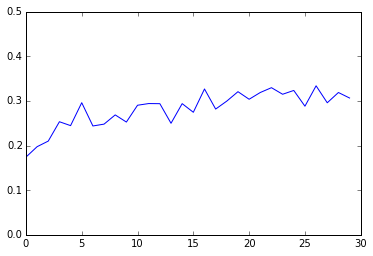

In [127]:
fig, ax = plt.subplots()
ax.plot(corrs, )
ax.set_ylim(0,.5)

In [118]:
plt.ylim?

In [11]:
for p, c in zip(prior_offense_avg, cur_offense):
    # print p, c
    print round(pearsonr(dfTG.loc[dfTG.nGm > 0].dropna(subset = [c])[p].values,
         dfTG.loc[dfTG.nGm > 0, c].dropna().values
         )[0], 4), '\t',
    print c

0.3017 	fg
0.3082 	fga
0.214 	fg_pct
0.327 	fg2
0.397 	fg2a
0.2026 	fg2_pct
0.3131 	fg3
0.4325 	fg3a
0.08 	fg3_pct
0.2068 	ft
0.2183 	fta
0.1699 	ft_pct
0.2955 	orb
0.2286 	drb
0.3017 	trb
0.2947 	ast
0.2915 	stl
0.3684 	blk
0.2846 	tov
0.3003 	pf
0.3439 	pts


##### Scale Game Stats

In [12]:
dfTG_scaled = dfTG[[c for c in dfTG.columns if 'cum' not in c]].copy()
dfTG_scaled = dfTG_scaled[dfTG_scaled.nGm > 0]
omit_cols = ['season', 'mp', 'pts', 'pts_opp', 'pts_net']
cols_to_scale = [c for c in dfTG_scaled.columns.tolist() if (c not in omit_cols) & ((isinstance(dfTG_scaled[c].values[0], int)) | (isinstance(dfTG_scaled[c].values[0], float)))]   

# Scale columns, ignore each team's first game (mp_prior == 0)
dfTG_scaled.loc[:, cols_to_scale] = dfTG_scaled.loc[:, cols_to_scale].apply(lambda c: (c - c.mean())/c.std(), axis = 0)

dfTG_scaled.reset_index(inplace = True, drop = True)

In [13]:
dfTG_scaled[dfTG_scaled.columns[:10]].head()

,nGm,season,dt,gm,team,home_team,conf_game,result_win,mp,fg
0,-1.649065,2012,2011-11-12,2011-11-12-air-force,air-force,True,False,True,200,0.907341
1,-1.537652,2012,2011-11-23,2011-11-23-air-force,air-force,True,False,False,225,0.268505
2,-1.426239,2012,2011-12-03,2011-12-03-drake,air-force,False,False,False,200,-1.648003
3,-1.314826,2012,2011-12-07,2011-12-07-air-force,air-force,True,False,True,200,-1.009167
4,-1.203413,2012,2011-12-10,2011-12-10-air-force,air-force,True,False,True,200,0.055560


In [14]:
for p, c in zip(prior_offense_avg, cur_offense):
    # print p, c
    print round(pearsonr(dfTG_scaled.loc[dfTG_scaled.nGm > 0].dropna(subset = [c])[p].values,
         dfTG_scaled.loc[dfTG_scaled.nGm > 0, c].dropna().values
         )[0], 4), '\t',
    print c

0.3031 	fg
0.3372 	fga
0.2236 	fg_pct
0.3366 	fg2
0.4294 	fg2a
0.2137 	fg2_pct
0.3498 	fg3
0.4703 	fg3a
0.1049 	fg3_pct
0.2267 	ft
0.2397 	fta
0.215 	ft_pct
0.337 	orb
0.2277 	drb
0.3138 	trb
0.3135 	ast
0.3161 	stl
0.3818 	blk
0.3191 	tov
0.3171 	pf
0.334 	pts


In [19]:
prior_cols = [c for c in dfTG_scaled.columns if 'prior' in c]
# corr = dfTG_scaled[prior_cols].corrwith(dfTG_scaled.pts_net)
corr = dfTG_scaled[fourFacCols].corrwith(dfTG_scaled.pts_net)
corr.sort(ascending = False, inplace = True)
corr
# dfTG_scaled[all_num_cols].corr().to_csv('stats_corr_matrix.csv')

pts_prior_avg    0.248555
ast_prior_avg    0.227480
trb_prior_avg    0.192655
drb_prior_avg    0.187895
blk_prior_avg    0.158349
stl_prior_avg    0.107770
pf_prior_avg    -0.109430
tov_prior_avg   -0.153158
dtype: float64

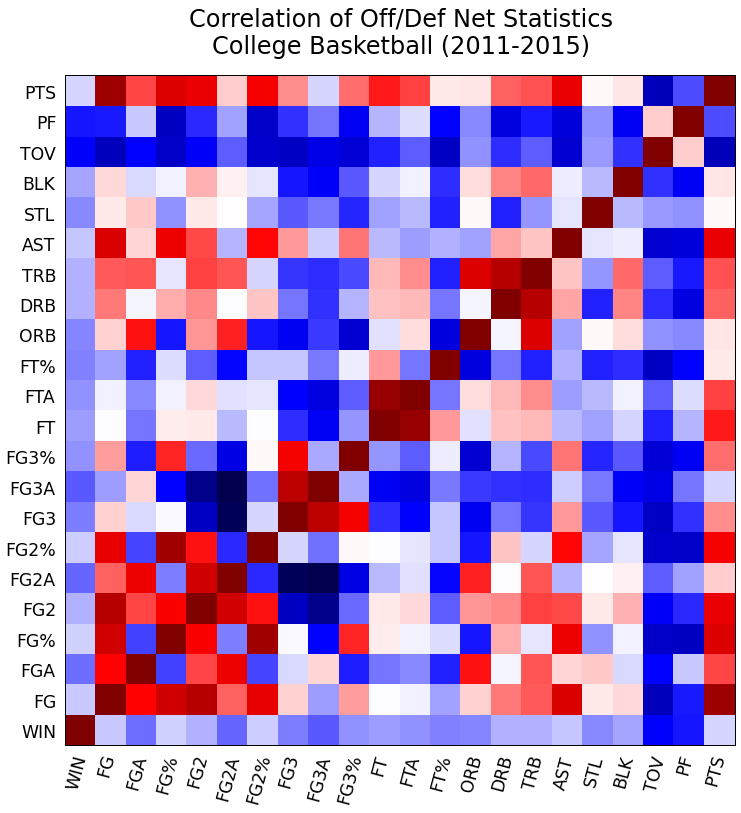

In [21]:
# prior_net = [c for c in prior_cols if 'net' in c]
prior_net = prior_offense_avg
win_corr = dfTG_scaled[['result_win'] + prior_net].corr()
# net_cols = [c for c in cols_to_scale if ('net' in c) & ('prior' not in c)]
# win_corr = dfTG_scaled[['result_win'] + net_cols].corr()
# win_corr

fig, ax = plt.subplots(figsize = (12, 12))
ax.pcolor(win_corr, cmap = plt.cm.seismic)

labelcols = ['WIN'] + [c.replace('_prior_avg', '').replace('_pct', '%').upper() for c in prior_net]
# labelcols = ['WIN'] + [c.replace('_net', '').replace('_pct', '%').upper() for c in net_cols]
ax.set_xlim(0, len(labelcols))
ax.set_ylim(0, len(labelcols))
ax.set_xticks([x+.4 for x in range(len(labelcols))]);
ax.set_xticklabels(labelcols);

ax.set_yticks([x+.4 for x in range(len(labelcols))]);
ax.set_yticklabels(labelcols);

ax.tick_params(bottom = False, 
               top = False, 
               left = False, 
               right = False, 
               labelsize = 'xx-large',
               pad = 10
              )
plt.xticks(rotation = 75);
plt.title('Correlation of Off/Def Net Statistics\nCollege Basketball (2011-2015)', fontsize = 24, y = 1.025);
# plt.savefig('corr_net_stats.png')

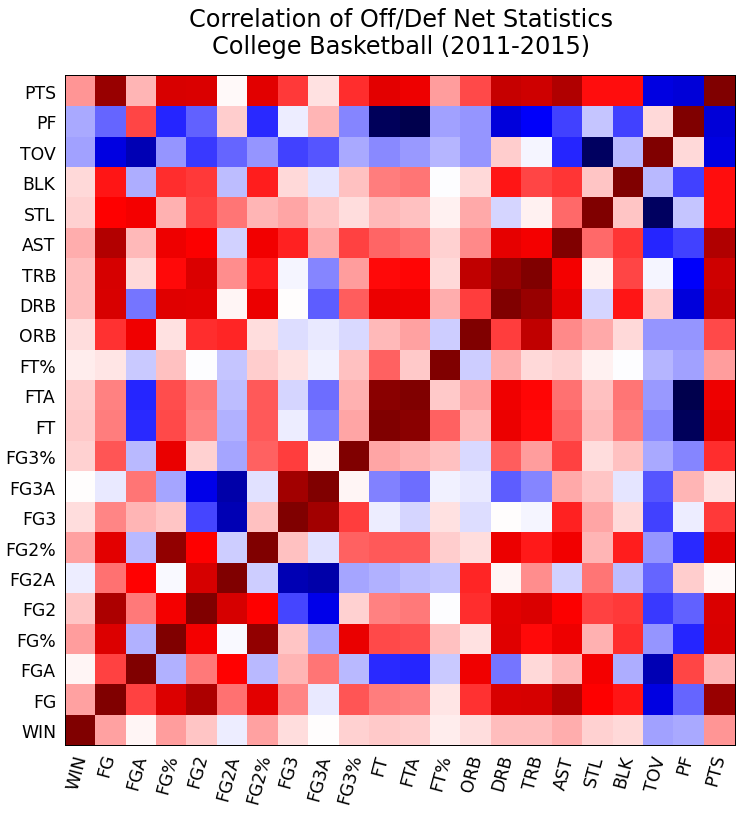

In [240]:
prior_net = [c for c in prior_cols if 'net' in c]
win_corr = dfTG_scaled[['result_win'] + prior_net].corr()
# net_cols = [c for c in cols_to_scale if ('net' in c) & ('prior' not in c)]
# win_corr = dfTG_scaled[['result_win'] + net_cols].corr()
# win_corr

fig, ax = plt.subplots(figsize = (12, 12))
ax.pcolor(win_corr, cmap = plt.cm.seismic)

labelcols = ['WIN'] + [c.replace('_net_prior', '').replace('_pct', '%').upper() for c in prior_net]
# labelcols = ['WIN'] + [c.replace('_net', '').replace('_pct', '%').upper() for c in net_cols]
ax.set_xlim(0, len(labelcols))
ax.set_ylim(0, len(labelcols))
ax.set_xticks([x+.4 for x in range(len(labelcols))]);
ax.set_xticklabels(labelcols);

ax.set_yticks([x+.4 for x in range(len(labelcols))]);
ax.set_yticklabels(labelcols);

ax.tick_params(bottom = False, 
               top = False, 
               left = False, 
               right = False, 
               labelsize = 'xx-large',
               pad = 10
              )
plt.xticks(rotation = 75);
plt.title('Correlation of Off/Def Net Statistics\nCollege Basketball (2011-2015)', fontsize = 24, y = 1.025);
# plt.savefig('corr_net_stats.png')

In [22]:
dfcorr = pd.DataFrame(corr, columns = ['corr'])
dfcorr['abs_corr'] = abs(dfcorr['corr'])
dfcorr.sort('abs_corr', ascending = False, inplace = True)
dfcorr

,corr,abs_corr
pts_prior_avg,0.248555,0.248555
ast_prior_avg,0.227480,0.227480
trb_prior_avg,0.192655,0.192655
drb_prior_avg,0.187895,0.187895
blk_prior_avg,0.158349,0.158349
tov_prior_avg,-0.153158,0.153158
pf_prior_avg,-0.109430,0.109430
stl_prior_avg,0.107770,0.107770


In [16]:
# test_cols = dfcorr.loc[dfcorr.abs_corr > .15, ].index.tolist()
# test_cols = [c for c in dfcorr.index.tolist() if 'net' in c][:8]
# test_cols = fourFacCols
test_cols = prior_offense_avg
target_col = 'pts_net'

In [17]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor, LogisticRegression
# # from sklearn.pipeline import Pipeline
# from sklearn.metrics import mean_squared_error
from sklearn.cross_validation import train_test_split, KFold
# # from itertools import combinations
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# import random

In [18]:
def mae_mse(ytrue, yhat):
    mae = np.mean([abs(yh - yt) for yt, yh in zip(ytrue, yhat)])
    mse = np.mean([pow((yh - yt), 2) for yt, yh in zip(ytrue, yhat)])
    return mae, mse

In [19]:
X = dfTG_scaled[test_cols]
y = dfTG_scaled[target_col]
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y)

In [20]:
k_folds = 10
k_folder = KFold(len(Xtrain)-1, n_folds = k_folds, shuffle = True)
kfold_ind = []

In [21]:
regSGD = SGDRegressor(loss = 'squared_loss', alpha = .0000001)

for ii, kf in enumerate(k_folder):
    train_index = kf[0]
    test_index = kf[1]
    kfold_ind.append({'train' : train_index,
                 'test' : test_index})
    
    regSGD.fit(Xtrain[train_index], ytrain[train_index])

    kfold_ind[ii]['mae_train'], kfold_ind[ii]['mse_train'] =  mae_mse(ytrain[train_index], regSGD.predict(Xtrain[train_index]))
    kfold_ind[ii]['mae_test'], kfold_ind[ii]['mse_test'] =  mae_mse(ytrain[test_index], regSGD.predict(Xtrain[test_index]))
    
    

In [24]:
print np.mean([k['mae_test'] for k in kfold_ind])
print np.mean([k['mse_test'] for k in kfold_ind])

10.9166591826
190.396509271


In [31]:
# regSGD.fit(Xtrain, ytrain)

In [32]:
degree = 2
# a = 1
model = LogisticRegression
# clf = make_pipeline(PolynomialFeatures(degree), Ridge(alpha = a))
clf = make_pipeline(PolynomialFeatures(degree), model(C = 10))
# clf.fit(Xtrain, ytrain)

In [ ]:
clf.fit(Xtrain, ytrain)

In [100]:
# clf.score(Xtest, ytest)
yhat = clf.predict(Xtest)
mae, mse = mae_mse(ytest, yhat)

print mae, mse

9.45056884006 141.493963095


In [168]:
min_mse = 1e10
min_alpha = None
alphas = [pow(10, -n) for n in range(10)]
for a in alphas:
    clf = ElasticNet(alpha = a, normalize = True)
    clf.fit(Xtrain, ytrain)
    mae, mse = mae_mse(ytest, clf.predict(Xtest))
    print a, mse
    if mse < min_mse:
        min_mse = mse
        min_alpha = a

1 212.715390718
0.1 212.715390718
0.01 212.388996628
0.001 208.345757721
0.0001 193.659356126
1e-05 187.908108707
1e-06 187.96038319
1e-07 187.99756737
1e-08 188.00170145
1e-09 188.00211915


In [151]:
ypred = clf.predict(Xtest)

In [152]:
print clf.score(Xtrain, ytrain)
print clf.score(Xtest, ytest)


0.124780273549
0.115352076785


(0, 20)

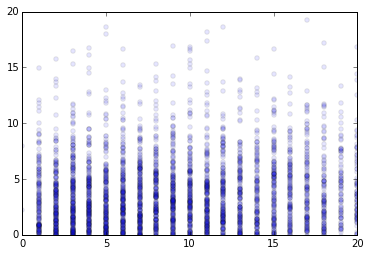

In [154]:
plt.scatter(ytest, ypred, alpha = 0.1)
plt.xlim([0,20])
plt.ylim([0,20])

In [157]:
dfpred = pd.DataFrame(zip(ytest, ypred), columns = ['ytrue', 'ypred'])
dfpred['err'] = dfpred.ypred - dfpred.ytrue
dfpred['abs_err'] = abs(dfpred.err)

In [158]:
dfpred.head()

,ytrue,ypred,err,abs_err
0,-9,-3.979254,5.020746,5.020746
1,-9,3.072004,12.072004,12.072004
2,11,2.743676,-8.256324,8.256324
3,23,9.724161,-13.275839,13.275839
4,6,6.443912,0.443912,0.443912


In [163]:
plt.hist?

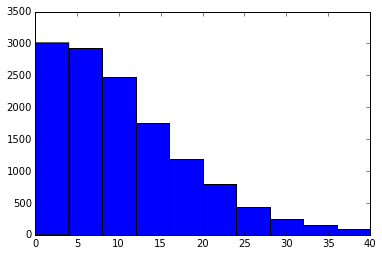

In [167]:
plt.hist(dfpred.abs_err, range = (0, 40));

In [141]:
# cm = pd.crosstab(ytest, ypred, rownames=["Actual"], colnames=["Predicted"])
# cm